In [1]:
"""
ADHD Prediction Dataset - Modelling & Evaluation Module

This notebook implements and evaluates machine learning models for ADHD prediction,
including hyperparameter optimization, model comparison, and final performance assessment.

Author: [Your Name]
Date: [Date]
Project: ADHD Sex Prediction
Input: Final engineered dataset from Feature Engineering module
Output: Optimized models, performance metrics, and deployment-ready artifacts
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# =============================================================================
# CONFIGURATION AND SETTINGS
# =============================================================================

# Set random seed for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.25  # 0.25 of remaining 80% = 20% of total

# Model evaluation settings
CV_FOLDS = 5
SCORING_METRIC = 'f1_macro'
N_JOBS = -1



In [2]:
# =============================================================================
# DATA LOADING AND PREPARATION
# =============================================================================

def load_and_prepare_data():
    """
    Load final engineered dataset and prepare for modeling.
    
    Returns:
    --------
    df : pd.DataFrame
        Loaded dataset ready for modeling.
    """

    
    # Load final dataset
    data_path = r"C:\Users\04ama\Downloads\raw adhd data\raw_dataset.csv"
    
    try:
        df = pd.read_csv(data_path)
      
        print(f"   Dataset shape: {df.shape}")
        
       
        
        return df
        
    except Exception as e:
        print(f" Error loading dataset: {str(e)}")
        raise

# Load and prepare data
df = load_and_prepare_data()

   Dataset shape: (1213, 19930)


In [3]:
# =============================================================================
# DATA LOADING AND PREPROCESSING WITH SAVED ARTIFACTS
# =============================================================================

import joblib
import json
from imblearn.over_sampling import ADASYN
from collections import Counter

def load_and_preprocess_data():
    """
    Load  preprocessing using saved artifacts.
    
    Returns:
    --------
    tuple
        (X_train_balanced, y_train_balanced, X_val, y_val, X_test, y_test)
    """
    print("🔄 LOADING PREPROCESSING ARTIFACTS")
    print("=" * 60)
    
   
    
    # Load saved preprocessing artifacts
    try:
        scaler = joblib.load('scaler.joblib')
        imputer = joblib.load('imputer.joblib') 
        encoder = joblib.load('encoder.joblib')
        pca = joblib.load('pca_connectome.joblib')
        print("   ✅ Preprocessing artifacts loaded successfully")
        
        # Load feature group definitions
        with open('quant_cols.json', 'r') as f:
            quant_cols = json.load(f)
        with open('cat_cols.json', 'r') as f:
            cat_cols = json.load(f)
        with open('conn_cols.json', 'r') as f:
            conn_cols = json.load(f)
            
        print(f"   📋 Feature groups loaded:")
        print(f"   Quantitative: {len(quant_cols)} features")
        print(f"     Categorical: {len(cat_cols)} features")
        print(f"    Connectome: {len(conn_cols)} features")

    except FileNotFoundError as e:
        print(f" Error loading preprocessing artifacts: {e}")
        print(" Make sure to run the data preprocessing notebook first")
        raise
    
    # Step 1: Split data FIRST (before any preprocessing)
    print("\n SPLITTING DATA (BEFORE PREPROCESSING)")
    print("-" * 40)
    
    X = df.drop(columns=['ADHD_Outcome', 'participant_id'], errors='ignore')
    y = df['ADHD_Outcome']
    
    # First split: train+val vs test (80% vs 20%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    
    # Second split: train vs val (60% vs 20% of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_temp
    )
    
    print(f"  Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X):.1%})")
    print(f"   Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X):.1%})")
    print(f"   Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X):.1%})")
    
    # Step 2: Apply preprocessing using saved artifacts
    print("\n APPLYING PREPROCESSING")
    print("-" * 40)
    
    def preprocess_split(X_split, fit_mode=False):
        """Apply preprocessing to a data split."""
        X_processed = X_split.copy()
        
        # 1. Scale quantitative features
        existing_quant = [col for col in quant_cols if col in X_processed.columns]
        if existing_quant:
            if fit_mode:
                X_processed[existing_quant] = scaler.fit_transform(X_processed[existing_quant])
            else:
                X_processed[existing_quant] = scaler.transform(X_processed[existing_quant])
        
        # 2. Impute missing values 
        all_feature_cols = existing_quant + [col for col in cat_cols if col in X_processed.columns]
        if all_feature_cols:
            if fit_mode:
                X_processed[all_feature_cols] = imputer.fit_transform(X_processed[all_feature_cols])
            else:
                X_processed[all_feature_cols] = imputer.transform(X_processed[all_feature_cols])
        
        # 3. Apply PCA to connectome features
        existing_conn = [col for col in conn_cols if col in X_processed.columns]
        if existing_conn:
            if fit_mode:
                conn_pca = pca.fit_transform(X_processed[existing_conn])
            else:
                conn_pca = pca.transform(X_processed[existing_conn])
            
            # Create PCA dataframe
            pca_cols = [f'conn_{i+1}' for i in range(conn_pca.shape[1])]
            conn_pca_df = pd.DataFrame(conn_pca, columns=pca_cols, index=X_processed.index)
            
            # Replace connectome columns with PCA components
            X_processed = X_processed.drop(columns=existing_conn)
            X_processed = pd.concat([X_processed, conn_pca_df], axis=1)
        
        # 4. One-hot encode categorical features
        existing_cat = [col for col in cat_cols if col in X_processed.columns]
        if existing_cat:
            if fit_mode:
                encoded = encoder.fit_transform(X_processed[existing_cat])
            else:
                encoded = encoder.transform(X_processed[existing_cat])
            
            # Create encoded dataframe
            encoded_df = pd.DataFrame(
                encoded, 
                columns=encoder.get_feature_names_out(existing_cat),
                index=X_processed.index
            )
            
            # Replace categorical columns
            X_processed = X_processed.drop(columns=existing_cat)
            X_processed = pd.concat([X_processed, encoded_df], axis=1)
        
        return X_processed
    
    # Fit preprocessing on training data and transform all splits
    print("   Fitting preprocessors on training data...")
    X_train_processed = preprocess_split(X_train, fit_mode=True)
    
    print("   Transforming validation and test sets...")
    X_val_processed = preprocess_split(X_val, fit_mode=False)
    X_test_processed = preprocess_split(X_test, fit_mode=False)
    
    print(f" Preprocessing complete:")
    print(f"    Training features: {X_train_processed.shape[1]}")
    print(f"    Validation features: {X_val_processed.shape[1]}")
    print(f"    Test features: {X_test_processed.shape[1]}")

    # Step 3: Apply ADASYN ONLY to training data
    print("\n🎯 APPLYING ADASYN TO TRAINING DATA ONLY")
    print("-" * 40)
    
    # Check original class distribution
    original_counts = Counter(y_train)
    original_ratio = max(original_counts.values()) / min(original_counts.values())
    print(f"   📊 Original training distribution: {dict(original_counts)}")
    print(f"   📊 Original imbalance ratio: {original_ratio:.3f}:1")
    
    # Apply ADASYN
    adasyn = ADASYN(n_neighbors=15, random_state=RANDOM_STATE, sampling_strategy='auto')
    X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_processed, y_train)
    
    # Check new class distribution
    new_counts = Counter(y_train_balanced)
    new_ratio = max(new_counts.values()) / min(new_counts.values())
    print(f"  ADASYN applied successfully:")
    print(f"     New training distribution: {dict(new_counts)}")
    print(f"    New imbalance ratio: {new_ratio:.3f}:1")
    print(f"    Samples added: {len(X_train_balanced) - len(X_train_processed):,}")
    print(f"    Balance improvement: {original_ratio - new_ratio:.3f}")

    # Validation and test sets remain unchanged (no data leakage!)
    print(f"\n DATA PREPARATION COMPLETE (NO DATA LEAKAGE)")
    print(f"    Training (balanced): {X_train_balanced.shape}")
    print(f"   Validation (original): {X_val_processed.shape}")  
    print(f"  Test (original): {X_test_processed.shape}")
    
    return X_train_balanced, y_train_balanced, X_val_processed, y_val, X_test_processed, y_test

# Replace your current data loading section with this
X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data()

🔄 LOADING PREPROCESSING ARTIFACTS
   ✅ Preprocessing artifacts loaded successfully
   📋 Feature groups loaded:
   Quantitative: 17 features
     Categorical: 11 features
    Connectome: 19900 features

 SPLITTING DATA (BEFORE PREPROCESSING)
----------------------------------------
  Train set: 727 samples (59.9%)
   Validation set: 243 samples (20.0%)
   Test set: 243 samples (20.0%)

 APPLYING PREPROCESSING
----------------------------------------
   Fitting preprocessors on training data...
   Transforming validation and test sets...
 Preprocessing complete:
    Training features: 890
    Validation features: 890
    Test features: 890

🎯 APPLYING ADASYN TO TRAINING DATA ONLY
----------------------------------------
   📊 Original training distribution: {0: 229, 1: 498}
   📊 Original imbalance ratio: 2.175:1
  ADASYN applied successfully:
     New training distribution: {0: 499, 1: 498}
    New imbalance ratio: 1.002:1
    Samples added: 270
    Balance improvement: 1.173

 DATA PREPA

In [4]:
# =============================================================================
# LOGISTIC REGRESSION OPTIMIZATION
# =============================================================================

def optimize_logistic_regression(X_train, y_train, cv_folds=CV_FOLDS):
    """
    Perform hyperparameter optimization for Logistic Regression.
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training target
    cv_folds : int
        Number of cross-validation folds
    
    Returns:
    --------
    GridSearchCV
        Fitted grid search object with best model
    """

    
    # Define parameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }
    
   

    
    # Initialize model with balanced class weights
    lr = LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE, 
        class_weight='balanced'
    )
    
    # Perform grid search
    print(f"  Running {cv_folds}-fold cross-validation ")
    grid_search = GridSearchCV(
        lr, param_grid, 
        cv=cv_folds, 
        scoring=SCORING_METRIC, 
        verbose=0, 
        n_jobs=N_JOBS
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best CV {SCORING_METRIC.upper()} score: {grid_search.best_score_:.4f}")
    
    return grid_search

# Optimize Logistic Regression
lr_grid_search = optimize_logistic_regression(X_train, y_train)

  Running 5-fold cross-validation 
  Best parameters: {'C': 100, 'solver': 'lbfgs'}
  Best CV F1_MACRO score: 0.8970


In [5]:
# =============================================================================
# LIGHTGBM OPTIMIZATION
# =============================================================================

def optimize_lightgbm(X_train, y_train, cv_folds=CV_FOLDS):
    """
    Perform hyperparameter optimization for LightGBM.
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training target
    cv_folds : int
        Number of cross-validation folds
    
    Returns:
    --------
    GridSearchCV
        Fitted grid search object with best model
    """

    
    # Define parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5],
        'num_leaves': [31, 50],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
   
    
   
    
    # Initialize LightGBM with balanced class weights
    lgbm = lgb.LGBMClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced',
        verbose=-1  # Suppress training output
    )
    
    # Perform grid search
    print(f"  Running {cv_folds}-fold cross-validation...")
    
    
    grid_search = GridSearchCV(
        lgbm, param_grid,
        cv=cv_folds,
        scoring=SCORING_METRIC,
        verbose=0,
        n_jobs=N_JOBS
    )
    
    grid_search.fit(X_train, y_train)
    
    
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best CV {SCORING_METRIC.upper()} score: {grid_search.best_score_:.4f}")
    
    return grid_search

# Optimize LightGBM
lgbm_grid_search = optimize_lightgbm(X_train, y_train)

  Running 5-fold cross-validation...
   Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
   Best CV F1_MACRO score: 0.8543


In [6]:
# =============================================================================
# MODEL COMPARISON ON VALIDATION SET
# =============================================================================

def compare_models_on_validation(models_dict, X_val, y_val):
    """
    Compare optimized models on validation set to select best performer.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of model names and fitted GridSearchCV objects
    X_val : pd.DataFrame
        Validation features
    y_val : pd.Series
        Validation target
    
    Returns:
    --------
    tuple
        (best_model_name, best_model, validation_results)
    """
    print(" Model Comparison on Validation Set")
   
    
    validation_results = {}
    
    for model_name, grid_search in models_dict.items():
        print(f"\n  Evaluating {model_name}:")
        
        # Get best model from grid search
        best_model = grid_search.best_estimator_
        
        # Make predictions on validation set
        y_val_pred = best_model.predict(X_val)
        y_val_proba = best_model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        report = classification_report(y_val, y_val_pred, output_dict=True)
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        roc_auc = auc(fpr, tpr)
        
        validation_results[model_name] = {
            'model': best_model,
            'accuracy': accuracy_score(y_val, y_val_pred),
            'f1_macro': report['macro avg']['f1-score'],
            'precision_macro': report['macro avg']['precision'],
            'recall_macro': report['macro avg']['recall'],
            'roc_auc': roc_auc,
            'cv_score': grid_search.best_score_
        }
        
        print(f"     CV Score: {grid_search.best_score_:.4f}")
        print(f"     Validation F1-Macro: {report['macro avg']['f1-score']:.4f}")
        print(f"      Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
        print(f"      ROC AUC: {roc_auc:.4f}")
    
    # Select best model based on validation F1-macro score
    best_model_name = max(validation_results.keys(), 
                         key=lambda x: validation_results[x]['f1_macro'])
    best_model = validation_results[best_model_name]['model']
    
    print(f"\ Best Model Selection:")
    print(f"   {best_model_name}")
    print(f"    Validation F1-Macro: {validation_results[best_model_name]['f1_macro']:.4f}")
    print(f"    ROC AUC: {validation_results[best_model_name]['roc_auc']:.4f}")
    
 
    return best_model_name, best_model, validation_results

# Compare models
models_dict = {
    'Logistic Regression': lr_grid_search,
    'LightGBM': lgbm_grid_search
}

best_model_name, best_model, validation_results = compare_models_on_validation(
    models_dict, X_val, y_val
)

 Model Comparison on Validation Set

  Evaluating Logistic Regression:
     CV Score: 0.8970
     Validation F1-Macro: 0.7357
      Validation Accuracy: 0.7778
      ROC AUC: 0.7925

  Evaluating LightGBM:
     CV Score: 0.8543
     Validation F1-Macro: 0.7098
      Validation Accuracy: 0.7737
      ROC AUC: 0.7710
\ Best Model Selection:
   Logistic Regression
    Validation F1-Macro: 0.7357
    ROC AUC: 0.7925


<>:63: SyntaxWarning: invalid escape sequence '\ '
<>:63: SyntaxWarning: invalid escape sequence '\ '
C:\Users\04ama\AppData\Local\Temp\ipykernel_33056\1801752449.py:63: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Best Model Selection:")


 Analyzing feature importance for Logistic Regression

  Top 10 Most Important Features (Absolute Coefficients):
   1. MRI_Track_Age_at_Scan_7.886379: 9.8322
   2. MRI_Track_Age_at_Scan_8.861396: 8.8700
   3. MRI_Track_Age_at_Scan_12.781542: 8.7304
   4. MRI_Track_Age_at_Scan_9.1197578: 8.5358
   5. MRI_Track_Age_at_Scan_9.975245: 7.9038
   6. MRI_Track_Age_at_Scan_7.552019: 7.8856
   7. MRI_Track_Age_at_Scan_9.0026002: 7.8119
   8. MRI_Track_Age_at_Scan_10.703969: 7.4114
   9. MRI_Track_Age_at_Scan_11.212639: 7.2910
  10. MRI_Track_Age_at_Scan_6.804814: 7.1402


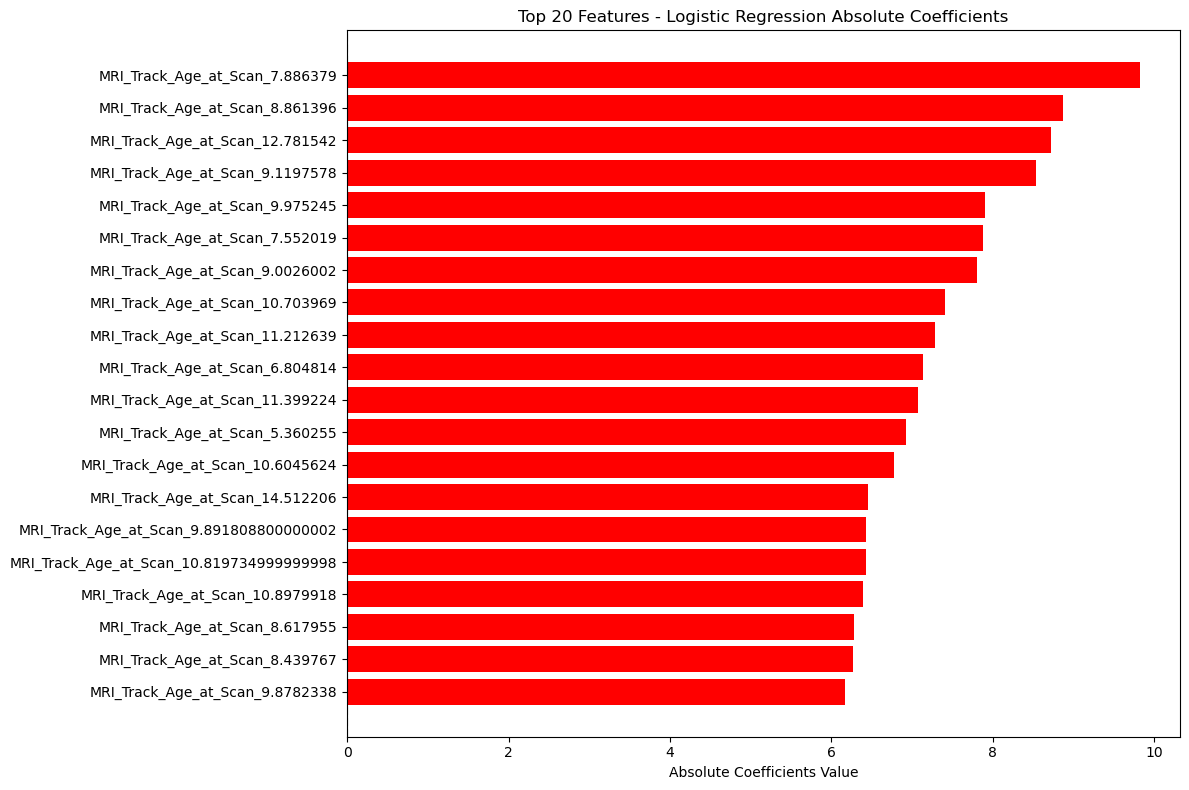

In [7]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

def analyze_feature_importance(best_model, best_model_name, feature_names):
    """
    Analyze and visualize feature importance for the best model.
    
    Parameters:
    -----------
    best_model : sklearn model
        Trained best model
    best_model_name : str
        Name of the best model
    feature_names : list
        List of feature names
    """
  
    print(f" Analyzing feature importance for {best_model_name}")
    
    if best_model_name == 'Logistic Regression':
        # For Logistic Regression, use coefficients
        importance_values = np.abs(best_model.coef_[0])
        importance_type = "Absolute Coefficients"
        
    elif best_model_name == 'LightGBM':
        # For LightGBM, use feature importance
        importance_values = best_model.feature_importances_
        importance_type = "Feature Importance"
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    }).sort_values('Importance', ascending=False)
    
    print(f"\n  Top 10 Most Important Features ({importance_type}):")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"  {i:2d}. {row['Feature']}: {row['Importance']:.4f}")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    
    if best_model_name == 'Logistic Regression':
        # Color code positive vs negative coefficients
        original_coefs = best_model.coef_[0]
        coef_dict = dict(zip(feature_names, original_coefs))
        colors = ['red']
    else:
        colors = 'skyblue'
    
    plt.barh(range(len(top_20)), top_20['Importance'], color=colors)
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel(f'{importance_type} Value')
    plt.title(f'Top 20 Features - {best_model_name} {importance_type}')
    
    if best_model_name == 'Logistic Regression':
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Analyze feature importance
feature_importance_df = analyze_feature_importance(
    best_model, best_model_name, X_train.columns.tolist()
)

An AUC of 0.8 in predicting ADHD cases means the model can correctly rank an ADHD case above a non-ADHD case 80% of the time. From a healthcare perspective, this is strong evidence the model can be used as a screening tool — for example, to prioritize which children should be referred for full clinical diagnosis. This improves efficiency by reducing wasted clinical resources while also supporting earlier interventions for children who are truly at risk

    Optimal threshold: 0.61
    Maximum F1-Macro: 0.7490


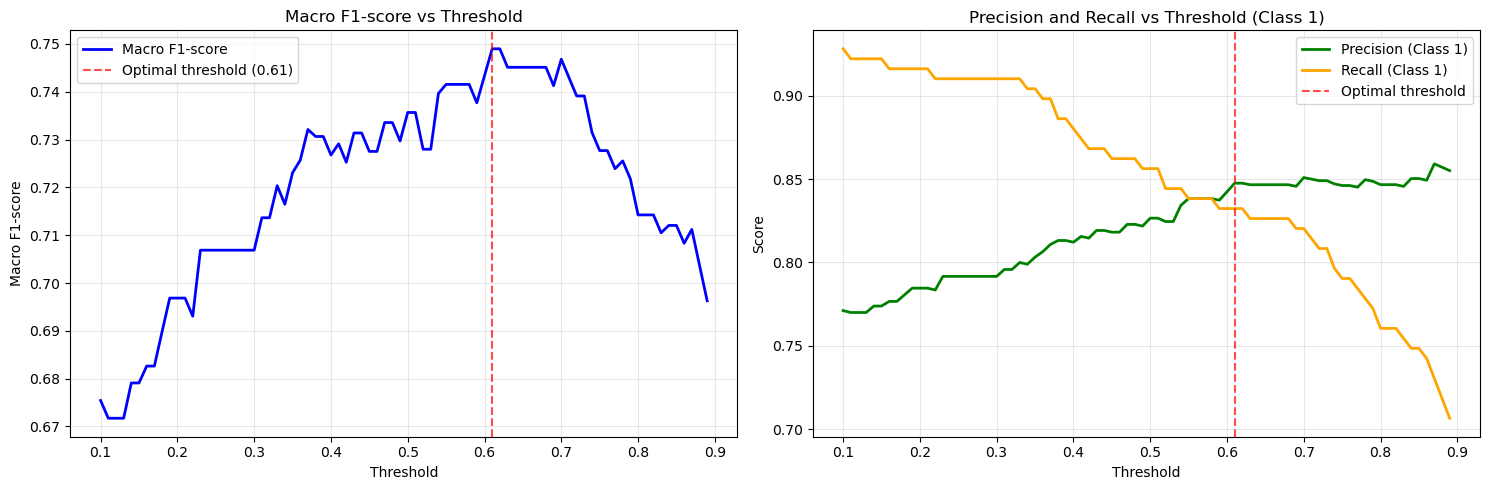

In [8]:
# =============================================================================
# THRESHOLD OPTIMIZATION
# =============================================================================

def optimize_classification_threshold(best_model, X_val, y_val):
    """
    Optimize classification threshold for best F1-macro score.
    
    Parameters:
    -----------
    best_model : sklearn model
        Trained best model
    X_val : pd.DataFrame
        Validation features
    y_val : pd.Series
        Validation target
    
    Returns:
    --------
    tuple
        (optimal_threshold, threshold_results)
    """
 
    # Get prediction probabilities
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    
    # Test different thresholds
    thresholds_range = np.arange(0.1, 0.9, 0.01) # 80 values from 0.1 to 0.89
    threshold_results = {
        'thresholds': thresholds_range,
        'f1_macro': [],
        'precision_1': [],
        'recall_1': [],
        'accuracy': []
    }
    
   
    
    for thresh in thresholds_range:
        y_pred_thresh = (y_val_proba >= thresh).astype(int)
        report = classification_report(y_val, y_pred_thresh, output_dict=True, zero_division=0)
        
        threshold_results['f1_macro'].append(report['macro avg']['f1-score'])
        threshold_results['precision_1'].append(report['1']['precision'])
        threshold_results['recall_1'].append(report['1']['recall'])
        threshold_results['accuracy'].append(accuracy_score(y_val, y_pred_thresh))
    
    # Find optimal threshold
    optimal_idx = np.argmax(threshold_results['f1_macro'])
    optimal_threshold = thresholds_range[optimal_idx]
    max_f1 = threshold_results['f1_macro'][optimal_idx]
    
    print(f"    Optimal threshold: {optimal_threshold:.2f}")
    print(f"    Maximum F1-Macro: {max_f1:.4f}")
    
    # Create threshold optimization plot
    create_threshold_plot(threshold_results, optimal_threshold)
    
    return optimal_threshold, threshold_results

def create_threshold_plot(threshold_results, optimal_threshold):
    """Create visualization for threshold optimization."""
   
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # F1-Macro vs Threshold
    ax1.plot(threshold_results['thresholds'], threshold_results['f1_macro'], 
             label='Macro F1-score', color='blue', linewidth=2)
    ax1.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal threshold ({optimal_threshold:.2f})')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Macro F1-score')
    ax1.set_title('Macro F1-score vs Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Precision and Recall vs Threshold
    ax2.plot(threshold_results['thresholds'], threshold_results['precision_1'], 
             label='Precision (Class 1)', color='green', linewidth=2)
    ax2.plot(threshold_results['thresholds'], threshold_results['recall_1'], 
             label='Recall (Class 1)', color='orange', linewidth=2)
    ax2.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal threshold')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Score')
    ax2.set_title('Precision and Recall vs Threshold (Class 1)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Optimize threshold
optimal_threshold, threshold_results = optimize_classification_threshold(
    best_model, X_val, y_val
)



    Final Test Set Results (Logistic Regression):
       Optimal threshold: 0.61
      • Macro F1-score: 0.7166
      • Macro Precision: 0.7191
      • Macro Recall: 0.7144
      • ROC AUC: 0.7773

   Class-specific Performance:
      • Class 0 (No ADHD):
         - Precision: 0.6216
         - Recall: 0.5974
      Class 1 (ADHD):
         - Precision: 0.8166
         - Recall: 0.8313


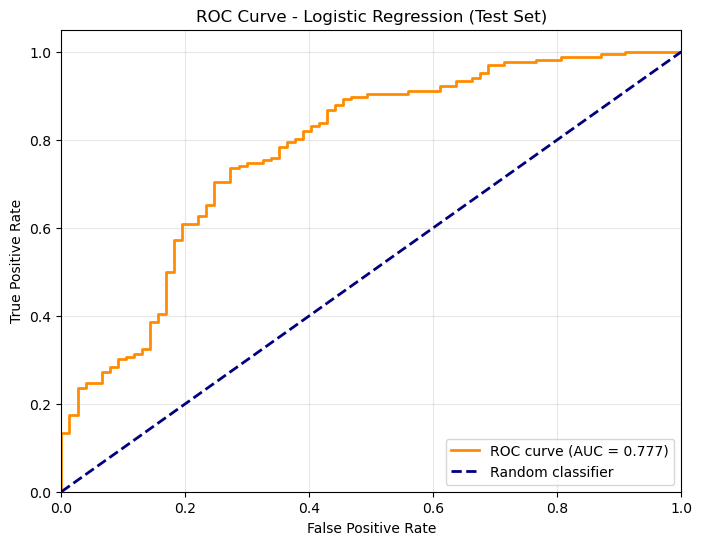

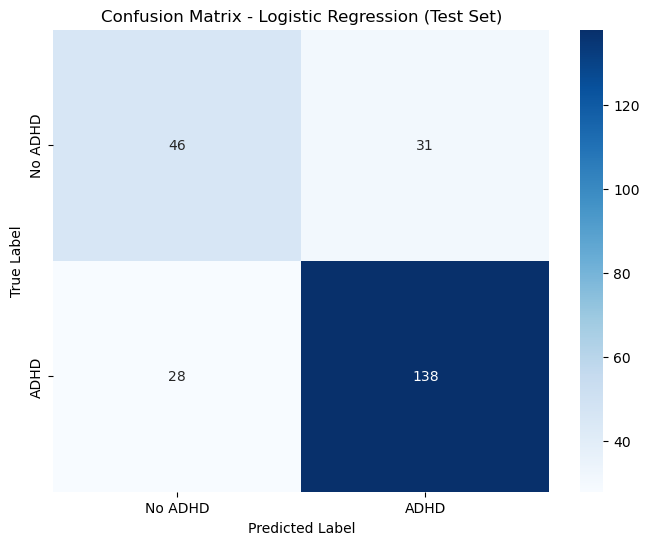

In [9]:
# =============================================================================
# FINAL TEST SET EVALUATION
# =============================================================================

def evaluate_final_model(best_model, best_model_name, optimal_threshold, X_test, y_test):
    """
    Perform final evaluation on untouched test set.
    
    Parameters:
    -----------
    best_model : sklearn model
        Trained best model
    best_model_name : str
        Name of best model
    optimal_threshold : float
        Optimized classification threshold
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        Test target
    
    Returns:
    --------
    dict
        Final test results
    """
    
    
    # Make predictions on test set
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= optimal_threshold).astype(int)
    
    # Calculate comprehensive metrics
    report = classification_report(y_test, y_test_pred, output_dict=True)
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    final_results = {
        'model_name': best_model_name,
        'optimal_threshold': optimal_threshold,
        'f1_macro': report['macro avg']['f1-score'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'precision_0': report['0']['precision'],
        'precision_1': report['1']['precision'],
        'recall_0': report['0']['recall'],
        'recall_1': report['1']['recall'],
        'roc_auc': roc_auc
    }
    
    print(f"    Final Test Set Results ({best_model_name}):")
    print(f"       Optimal threshold: {optimal_threshold:.2f}")
    print(f"      • Macro F1-score: {final_results['f1_macro']:.4f}")
    print(f"      • Macro Precision: {final_results['precision_macro']:.4f}")
    print(f"      • Macro Recall: {final_results['recall_macro']:.4f}")
    print(f"      • ROC AUC: {final_results['roc_auc']:.4f}")
    
    print(f"\n   Class-specific Performance:")
    print(f"      • Class 0 (No ADHD):")
    print(f"         - Precision: {final_results['precision_0']:.4f}")
    print(f"         - Recall: {final_results['recall_0']:.4f}")
    print(f"      Class 1 (ADHD):")
    print(f"         - Precision: {final_results['precision_1']:.4f}")
    print(f"         - Recall: {final_results['recall_1']:.4f}")
    
    # Create ROC curve
    create_roc_curve(fpr, tpr, roc_auc, best_model_name)
    
    # Create confusion matrix
    create_confusion_matrix(y_test, y_test_pred, best_model_name)
    
    return final_results

def create_roc_curve(fpr, tpr, roc_auc, model_name):
    """Create ROC curve visualization."""
    
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (Test Set)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

def create_confusion_matrix(y_true, y_pred, model_name):
    """Create confusion matrix visualization."""

    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No ADHD', 'ADHD'],
                yticklabels=['No ADHD', 'ADHD'])
    plt.title(f'Confusion Matrix - {model_name} (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Final evaluation
final_test_results = evaluate_final_model(
    best_model, best_model_name, optimal_threshold, X_test, y_test
)

In [10]:
# =============================================================================
# MODEL STABILITY ASSESSMENT
# =============================================================================

def assess_model_stability(best_model_name, best_params, optimal_threshold, X, y, n_seeds=10):
    """
    Assess model stability across different random seeds.
    
    Parameters:
    -----------
    best_model_name : str
        Name of best model
    best_params : dict
        Best hyperparameters
    optimal_threshold : float
        Optimal classification threshold
    X : pd.DataFrame
        Complete feature matrix
    y : pd.Series
        Complete target vector
    n_seeds : int
        Number of different seeds to test
    
    Returns:
    --------
    pd.DataFrame
        Stability results across seeds
    """

    
    seeds = [21, 42, 100, 123, 2025, 777, 999, 1234, 5678, 9999][:n_seeds]
    stability_results = []
    
    
    
    for i, seed in enumerate(seeds, 1):
        print(f"   Testing seed {seed} ({i}/{n_seeds})")
        
        # Split data with different seed
        X_temp, X_test_seed, y_temp, y_test_seed = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=seed, stratify=y
        )
        X_train_seed, X_val_seed, y_train_seed, y_val_seed = train_test_split(
            X_temp, y_temp, test_size=VAL_SIZE, random_state=seed, stratify=y_temp
        )
        
        # Train model with best parameters
        if best_model_name == 'Logistic Regression':
            model_seed = LogisticRegression(
                max_iter=1000, 
                random_state=seed, 
                class_weight='balanced',
                **best_params
            )
        elif best_model_name == 'LightGBM':
            model_seed = lgb.LGBMClassifier(
                random_state=seed,
                class_weight='balanced',
                verbose=-1,
                **best_params
            )
        
        model_seed.fit(X_train_seed, y_train_seed)
        
        # Evaluate on test set
        y_test_proba_seed = model_seed.predict_proba(X_test_seed)[:, 1]
        y_test_pred_seed = (y_test_proba_seed >= optimal_threshold).astype(int)
        
        report_seed = classification_report(y_test_seed, y_test_pred_seed, output_dict=True)
        fpr, tpr, _ = roc_curve(y_test_seed, y_test_proba_seed)
        
        stability_results.append({
            'seed': seed,
            'f1_macro': report_seed['macro avg']['f1-score'],
            'precision_1': report_seed['1']['precision'],
            'recall_1': report_seed['1']['recall'],
            'auc': auc(fpr, tpr)
        })
    
    stability_df = pd.DataFrame(stability_results)
    
    print(f"\n   Stability Results Summary (n={n_seeds} seeds):")
    for metric in ['f1_macro', 'precision_1', 'recall_1', 'auc']:
        mean_val = stability_df[metric].mean()
        std_val = stability_df[metric].std()
        print(f"      • {metric.replace('_', ' ').title():<15}: {mean_val:.4f} ± {std_val:.4f}")
    
    return stability_df

# Get best parameters
if best_model_name == 'Logistic Regression':
    best_params = lr_grid_search.best_params_
elif best_model_name == 'LightGBM':
    best_params = lgbm_grid_search.best_params_

# Assess model stability
stability_df = assess_model_stability(
    best_model_name, best_params, optimal_threshold, X, y
)

NameError: name 'X' is not defined

In [ ]:
# =============================================================================
# MODEL DEPLOYMENT PREPARATION
# =============================================================================

def save_model(best_model, best_model_name, optimal_threshold, 
                            final_results, validation_results):
    """
    Save model and configuration files for deployment.
    
    Parameters:
    -----------
    best_model : sklearn model
        Trained best model
    best_model_name : str
        Name of best model
    optimal_threshold : float
        Optimal classification threshold
    final_results : dict
        Final test results
    validation_results : dict
        Validation results for all models
    """
   
    
    # Save the model
    model_filename = f'{best_model_name.lower().replace(" ", "_")}_model.joblib'
    joblib.dump(best_model, model_filename)
    print(f"  Model saved as: {model_filename}")
    
    # Save optimal threshold
    threshold_config = {
        'threshold': optimal_threshold,
        'model_name': best_model_name,
        'optimization_metric': 'f1_macro'
    }
    
    with open('adhd_model_threshold.json', 'w') as f:
        json.dump(threshold_config, f, indent=2)
   
    
    # Save comprehensive model report
    model_report = {
        'model_info': {
            'name': best_model_name,
            'optimal_threshold': optimal_threshold
            },
        'performance': {
            'test_f1_macro': final_results['f1_macro'],
            'test_roc_auc': final_results['roc_auc'],
            'test_precision_adhd': final_results['precision_1'],
            'test_recall_adhd': final_results['recall_1']
        },
        'model_comparison': {
            model: {
                'validation_f1_macro': results['f1_macro'],
                'validation_roc_auc': results['roc_auc']
            }
            for model, results in validation_results.items()
        },
        'stability': {
            'mean_f1_macro': stability_df['f1_macro'].mean(),
            'std_f1_macro': stability_df['f1_macro'].std(),
            'mean_auc': stability_df['auc'].mean(),
            'std_auc': stability_df['auc'].std()
        }
    }
    
    with open('adhd_model_report.json', 'w') as f:
        json.dump(model_report, f, indent=2)
    print(f"  Model report saved as: adhd_model_report.json")
    
 
    print(f"    Model: {best_model_name}")
    print(f"    Test F1-Macro: {final_results['f1_macro']:.4f}")
    print(f"     AUC: {final_results['roc_auc']:.3f}")

# Save deployment artifacts
save_model(
    best_model, best_model_name, optimal_threshold, 
    final_test_results, validation_results
)

  Model saved as: logistic_regression_model.joblib
  Model report saved as: adhd_model_report.json
    Model: Logistic Regression
    Test F1-Macro: 0.7192
     AUC: 0.788
